In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

2023-08-19 17:14:13.082821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 17:14:14.101733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


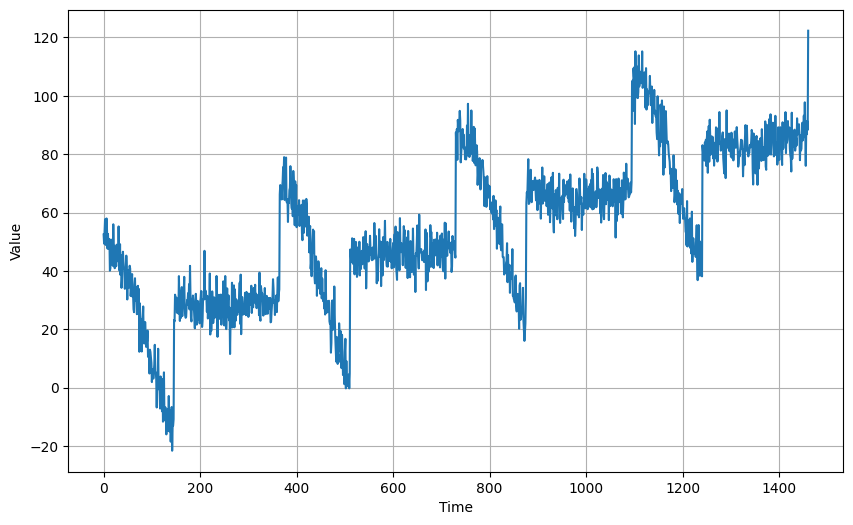

In [2]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series_noise = series + noise

plt.figure(figsize=(10, 6))
plot_series(time, series_noise)
plt.show()

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series_noise[:split_time]
time_valid = time[split_time:]
x_valid = series_noise[split_time:]

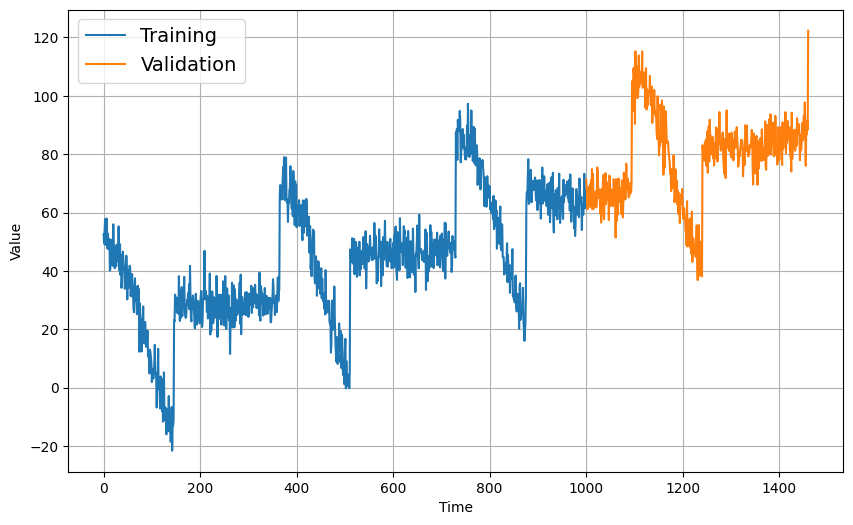

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, label='Training')
plot_series(time_valid, x_valid, label='Validation')
plt.show()

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100


2023-08-19 13:25:04.346663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:25:04.346973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 1s 7ms/step - loss: 18.9395 - mae: 19.4352 - val_loss: 8.1917 - val_mae: 8.6771
Epoch 2/100
 1/31 [..............................] - ETA: 1s - loss: 9.3042 - mae: 9.8042

2023-08-19 13:25:04.833501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:25:04.833900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 4ms/step - loss: 7.4185 - mae: 7.9042 - val_loss: 8.3215 - val_mae: 8.8086
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 7.0192 - mae: 7.5032 - val_loss: 7.3246 - val_mae: 7.8113
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 6.9845 - mae: 7.4655 - val_loss: 7.3362 - val_mae: 7.8248
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 6.8347 - mae: 7.3215 - val_loss: 7.2282 - val_mae: 7.7099
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 6.7058 - mae: 7.1881 - val_loss: 7.1866 - val_mae: 7.6730
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 6.6432 - mae: 7.1274 - val_loss: 7.0158 - val_mae: 7.5035
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 6.5967 - mae: 7.0798 - val_loss: 7.0982 - val_mae: 7.5857
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 6.5355 - mae: 7.0237 -

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2023-08-19 13:28:46.786112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:28:46.786453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 3ms/step - loss: 24.7586 - mae: 25.2570 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 12.5425 - mae: 13.0347 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 8.6636 - mae: 9.1489 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 8.6177 - mae: 9.1042 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5922 - mae: 9.0763 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5382 - mae: 9.0221 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5011 - mae: 8.9870 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4684 - mae: 8.9514 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4402 - mae: 8.9256 - lr: 1.8478e-06
Epoch 10/

(1e-06, 0.001, 0.0, 20.0)

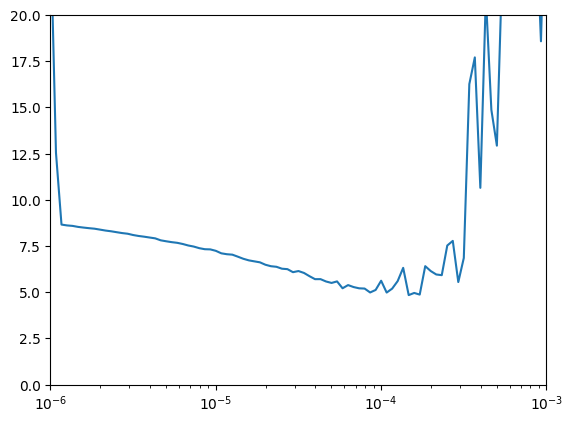

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


2023-08-19 13:30:30.345422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:30:30.345744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 1s 8ms/step - loss: 19.8702 - mae: 20.3674 - val_loss: 11.2458 - val_mae: 11.7333
Epoch 2/500


2023-08-19 13:30:30.840769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:30:30.841176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 4ms/step - loss: 10.7102 - mae: 11.1987 - val_loss: 9.5091 - val_mae: 9.9994
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 9.9427 - mae: 10.4262 - val_loss: 8.9593 - val_mae: 9.4510
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 9.4940 - mae: 9.9786 - val_loss: 8.7207 - val_mae: 9.2085
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 9.1668 - mae: 9.6532 - val_loss: 8.3418 - val_mae: 8.8238
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 8.8050 - mae: 9.2919 - val_loss: 7.9914 - val_mae: 8.4789
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 8.5144 - mae: 9.0017 - val_loss: 7.9078 - val_mae: 8.3954
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 8.3329 - mae: 8.8180 - val_loss: 7.7000 - val_mae: 8.1866
Epoch 9/500
31/31 [==============================] - 0s 4ms/step - loss: 8.0770 - mae: 8.563

In [3]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
lin_forecast = model_forecast(model, series_noise[split_time - window_size:-1], window_size)[:, 0]
lin_forecast.shape

15/15 [==============================] - 0s 4ms/step


2023-08-19 13:31:53.576178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:31:53.576512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]


(461,)

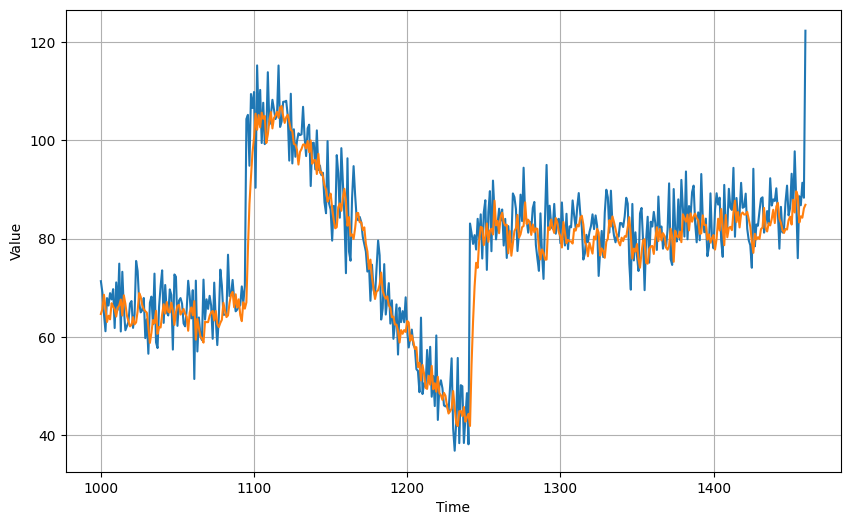

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.027709

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


2023-08-19 13:48:15.660981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:48:15.661359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 1s 8ms/step - loss: 24.6437 - mae: 25.1397 - val_loss: 7.0540 - val_mae: 7.5337
Epoch 2/500


2023-08-19 13:48:16.419981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:48:16.420392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 4ms/step - loss: 8.2749 - mae: 8.7633 - val_loss: 7.2321 - val_mae: 7.7151
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 7.3594 - mae: 7.8403 - val_loss: 6.5566 - val_mae: 7.0390
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 7.0287 - mae: 7.5123 - val_loss: 6.3282 - val_mae: 6.8159
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 6.8109 - mae: 7.2923 - val_loss: 6.2173 - val_mae: 6.7023
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 6.5914 - mae: 7.0722 - val_loss: 6.3277 - val_mae: 6.8039
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 6.4557 - mae: 6.9367 - val_loss: 6.1039 - val_mae: 6.5908
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 6.2954 - mae: 6.7750 - val_loss: 6.0644 - val_mae: 6.5492
Epoch 9/500
31/31 [==============================] - 0s 4ms/step - loss: 6.1586 - mae: 6.6387 -

In [26]:
dense_forecast = model_forecast(model, series_noise[split_time - window_size:-1], window_size)[:, 0]
dense_forecast.shape

15/15 [==============================] - 0s 3ms/step


2023-08-19 13:48:56.710384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:48:56.710818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]


(461,)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

# RNN

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2023-08-19 17:17:25.931654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-19 17:17:26.600141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-19 17:17:26.601053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-08-19 17:17:27.148496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:17:27.148863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:17:28.594167: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9734324160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-19 17:17:28.594201: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeFor

8/8 [==============================] - 2s 30ms/step - loss: 407.0696 - mae: 407.5696 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 262.2433 - mae: 262.7433 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 104.9712 - mae: 105.4712 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 41.5833 - mae: 42.0820 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 27ms/step - loss: 45.5787 - mae: 46.0774 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 27.9601 - mae: 28.4534 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 24.2698 - mae: 24.7648 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 22.8192 - mae: 23.3115 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 21.1902 - mae: 21.6822 - lr: 2.5119e-0

(1e-07, 0.0001, 0.0, 30.0)

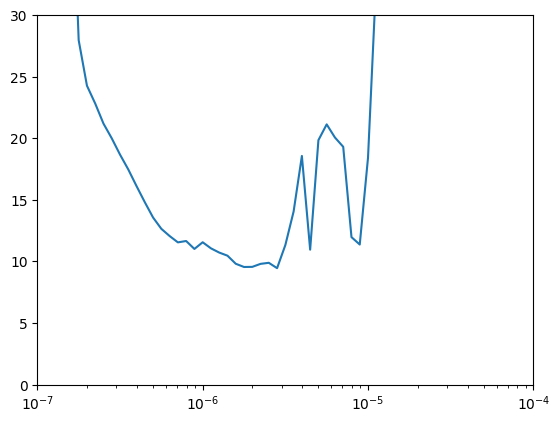

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


2023-08-19 17:18:57.067765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:18:57.068139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


      8/Unknown - 2s 27ms/step - loss: 177.2836 - mae: 177.7836

2023-08-19 17:18:58.813343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:18:58.813744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:18:59.400183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{no

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 4s 386ms/step - loss: 177.2836 - mae: 177.7836 - val_loss: 18.1594 - val_mae: 18.6575
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 82.9655 - mae: 83.4655

2023-08-19 17:19:01.850487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:01.860042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:01.996012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 346ms/step - loss: 82.2567 - mae: 82.7567 - val_loss: 12.4097 - val_mae: 12.8972
Epoch 3/500
8/8 [==============================] - 0s 38ms/step - loss: 43.6522 - mae: 44.1511 - val_loss: 59.7283 - val_mae: 60.2283
Epoch 4/500
8/8 [==============================] - 0s 36ms/step - loss: 27.4703 - mae: 27.9690 - val_loss: 26.4506 - val_mae: 26.9497
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 19.5192 - mae: 20.0119 - val_loss: 13.0169 - val_mae: 13.5121
Epoch 6/500
8/8 [==============================] - 0s 40ms/step - loss: 15.7167 - mae: 16.2073 - val_loss: 14.0457 - val_mae: 14.5404
Epoch 7/500
8/8 [==============================] - 0s 35ms/step - loss: 12.5460 - mae: 13.0356 - val_loss: 12.9377 - val_mae: 13.4292
Epoch 8/500
8/8 [==============================] - ETA: 0s - loss: 10.6595 - mae: 11.1465

2023-08-19 17:19:06.131497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:06.140083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:06.283098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 359ms/step - loss: 10.6595 - mae: 11.1465 - val_loss: 11.1302 - val_mae: 11.6194
Epoch 9/500
8/8 [==============================] - ETA: 0s - loss: 10.0300 - mae: 10.5161

2023-08-19 17:19:08.703550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:08.711095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:08.861497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 353ms/step - loss: 10.0300 - mae: 10.5161 - val_loss: 10.8158 - val_mae: 11.3063
Epoch 10/500
7/8 [=========================>....] - ETA: 0s - loss: 9.6546 - mae: 10.1394 

2023-08-19 17:19:11.273460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:11.280996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:11.417907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 331ms/step - loss: 9.5159 - mae: 10.0013 - val_loss: 9.8623 - val_mae: 10.3535
Epoch 11/500
8/8 [==============================] - ETA: 0s - loss: 9.1652 - mae: 9.6491 

2023-08-19 17:19:13.765380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:13.773586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:13.910245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 368ms/step - loss: 9.1652 - mae: 9.6491 - val_loss: 9.5051 - val_mae: 9.9944
Epoch 12/500
6/8 [=====================>........] - ETA: 0s - loss: 8.8884 - mae: 9.3673

2023-08-19 17:19:16.350103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:16.361451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:16.538437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 349ms/step - loss: 8.8075 - mae: 9.2873 - val_loss: 9.0004 - val_mae: 9.4928
Epoch 13/500
8/8 [==============================] - ETA: 0s - loss: 8.6268 - mae: 9.1060

2023-08-19 17:19:18.926216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:18.934464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:19.083221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 411ms/step - loss: 8.6268 - mae: 9.1060 - val_loss: 8.6125 - val_mae: 9.1038
Epoch 14/500
7/8 [=========================>....] - ETA: 0s - loss: 8.1758 - mae: 8.6592

2023-08-19 17:19:21.873379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:21.881481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:22.025511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 320ms/step - loss: 8.1790 - mae: 8.6613 - val_loss: 7.3121 - val_mae: 7.7947
Epoch 15/500
7/8 [=========================>....] - ETA: 0s - loss: 8.0115 - mae: 8.4937

2023-08-19 17:19:24.193108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:24.200205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:24.369035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 321ms/step - loss: 8.0194 - mae: 8.5003 - val_loss: 6.2544 - val_mae: 6.7393
Epoch 16/500
8/8 [==============================] - 0s 38ms/step - loss: 7.7580 - mae: 8.2390 - val_loss: 6.3431 - val_mae: 6.8303
Epoch 17/500
8/8 [==============================] - 0s 38ms/step - loss: 7.5589 - mae: 8.0401 - val_loss: 6.9673 - val_mae: 7.4549
Epoch 18/500
8/8 [==============================] - 0s 35ms/step - loss: 7.5394 - mae: 8.0230 - val_loss: 6.3026 - val_mae: 6.7846
Epoch 19/500
7/8 [=========================>....] - ETA: 0s - loss: 7.3837 - mae: 7.8658

2023-08-19 17:19:27.571966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:27.581591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:28.014606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 366ms/step - loss: 7.3027 - mae: 7.7842 - val_loss: 5.9268 - val_mae: 6.4055
Epoch 20/500
8/8 [==============================] - 0s 37ms/step - loss: 7.2377 - mae: 7.7189 - val_loss: 6.1716 - val_mae: 6.6538
Epoch 21/500
7/8 [=========================>....] - ETA: 0s - loss: 7.4785 - mae: 7.9597

2023-08-19 17:19:30.574171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:30.581661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:30.710685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 327ms/step - loss: 7.3701 - mae: 7.8522 - val_loss: 5.5414 - val_mae: 6.0196
Epoch 22/500
8/8 [==============================] - ETA: 0s - loss: 7.2595 - mae: 7.7450

2023-08-19 17:19:32.920224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:32.928907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:33.064201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 343ms/step - loss: 7.2595 - mae: 7.7450 - val_loss: 5.4251 - val_mae: 5.9022
Epoch 23/500
8/8 [==============================] - 0s 36ms/step - loss: 7.0150 - mae: 7.4937 - val_loss: 6.7605 - val_mae: 7.2462
Epoch 24/500
8/8 [==============================] - ETA: 0s - loss: 6.9336 - mae: 7.4143

2023-08-19 17:19:35.766224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:35.774896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:35.902016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 309ms/step - loss: 6.9336 - mae: 7.4143 - val_loss: 5.3811 - val_mae: 5.8668
Epoch 25/500
8/8 [==============================] - 0s 35ms/step - loss: 6.9539 - mae: 7.4379 - val_loss: 6.6831 - val_mae: 7.1685
Epoch 26/500
8/8 [==============================] - 0s 41ms/step - loss: 6.8481 - mae: 7.3289 - val_loss: 5.4248 - val_mae: 5.8996
Epoch 27/500
8/8 [==============================] - 0s 34ms/step - loss: 6.7085 - mae: 7.1909 - val_loss: 5.3888 - val_mae: 5.8642
Epoch 28/500
8/8 [==============================] - 0s 39ms/step - loss: 6.7157 - mae: 7.1984 - val_loss: 5.9181 - val_mae: 6.4004
Epoch 29/500
7/8 [=========================>....] - ETA: 0s - loss: 6.6153 - mae: 7.0961

2023-08-19 17:19:39.396205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:39.405275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:39.534526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 353ms/step - loss: 6.7785 - mae: 7.2587 - val_loss: 5.2538 - val_mae: 5.7405
Epoch 30/500
8/8 [==============================] - 0s 36ms/step - loss: 6.6161 - mae: 7.0976 - val_loss: 6.9125 - val_mae: 7.3957
Epoch 31/500
7/8 [=========================>....] - ETA: 0s - loss: 7.0329 - mae: 7.5172

2023-08-19 17:19:42.315596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:42.325930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:42.460012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 316ms/step - loss: 7.0102 - mae: 7.4944 - val_loss: 5.2135 - val_mae: 5.7004
Epoch 32/500
8/8 [==============================] - 0s 35ms/step - loss: 7.1276 - mae: 7.6106 - val_loss: 5.2225 - val_mae: 5.6982
Epoch 33/500
8/8 [==============================] - 0s 44ms/step - loss: 7.4808 - mae: 7.9700 - val_loss: 9.1448 - val_mae: 9.6375
Epoch 34/500
8/8 [==============================] - 0s 37ms/step - loss: 7.2254 - mae: 7.7108 - val_loss: 5.9933 - val_mae: 6.4757
Epoch 35/500
8/8 [==============================] - 0s 36ms/step - loss: 7.3429 - mae: 7.8280 - val_loss: 5.4244 - val_mae: 5.9007
Epoch 36/500
8/8 [==============================] - 0s 35ms/step - loss: 6.5414 - mae: 7.0234 - val_loss: 5.2675 - val_mae: 5.7407
Epoch 37/500
7/8 [=========================>....] - ETA: 0s - loss: 6.3834 - mae: 6.8634

2023-08-19 17:19:46.333904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:46.341712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:46.473940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 351ms/step - loss: 6.4161 - mae: 6.8964 - val_loss: 5.2042 - val_mae: 5.6832
Epoch 38/500
8/8 [==============================] - 0s 36ms/step - loss: 6.5239 - mae: 7.0050 - val_loss: 5.7491 - val_mae: 6.2298
Epoch 39/500
8/8 [==============================] - 0s 37ms/step - loss: 6.3813 - mae: 6.8628 - val_loss: 6.7915 - val_mae: 7.2767
Epoch 40/500
8/8 [==============================] - 0s 38ms/step - loss: 6.6917 - mae: 7.1731 - val_loss: 5.2571 - val_mae: 5.7461
Epoch 41/500
8/8 [==============================] - 0s 39ms/step - loss: 6.6524 - mae: 7.1332 - val_loss: 6.3025 - val_mae: 6.7873
Epoch 42/500
8/8 [==============================] - 0s 39ms/step - loss: 6.5875 - mae: 7.0668 - val_loss: 6.0778 - val_mae: 6.5628
Epoch 43/500
8/8 [==============================] - 0s 40ms/step - loss: 6.4172 - mae: 6.8975 - val_loss: 5.4187 - val_mae: 5.8985
Epoch 44/500
8/8 [=====================

2023-08-19 17:19:51.421163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:51.432278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:51.583799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 343ms/step - loss: 6.2507 - mae: 6.7313 - val_loss: 5.1442 - val_mae: 5.6321
Epoch 46/500
8/8 [==============================] - 0s 36ms/step - loss: 6.1510 - mae: 6.6310 - val_loss: 5.1831 - val_mae: 5.6555
Epoch 47/500
8/8 [==============================] - 0s 39ms/step - loss: 6.1389 - mae: 6.6188 - val_loss: 6.6777 - val_mae: 7.1622
Epoch 48/500
8/8 [==============================] - 0s 40ms/step - loss: 6.1192 - mae: 6.5990 - val_loss: 5.1857 - val_mae: 5.6606
Epoch 49/500
8/8 [==============================] - 0s 37ms/step - loss: 6.0439 - mae: 6.5245 - val_loss: 5.9182 - val_mae: 6.4039
Epoch 50/500
8/8 [==============================] - 0s 39ms/step - loss: 6.4162 - mae: 6.8965 - val_loss: 5.5796 - val_mae: 6.0569
Epoch 51/500
8/8 [==============================] - 0s 39ms/step - loss: 6.6080 - mae: 7.0885 - val_loss: 8.7452 - val_mae: 9.2374
Epoch 52/500
8/8 [=====================

2023-08-19 17:19:56.414149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:56.424385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:19:56.562076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 383ms/step - loss: 6.8282 - mae: 7.3103 - val_loss: 5.1356 - val_mae: 5.6113
Epoch 54/500
8/8 [==============================] - 0s 43ms/step - loss: 6.4838 - mae: 6.9634 - val_loss: 5.7519 - val_mae: 6.2330
Epoch 55/500
8/8 [==============================] - 0s 52ms/step - loss: 6.0613 - mae: 6.5405 - val_loss: 5.7120 - val_mae: 6.1931
Epoch 56/500
8/8 [==============================] - 0s 39ms/step - loss: 6.4633 - mae: 6.9420 - val_loss: 7.1302 - val_mae: 7.6145
Epoch 57/500
8/8 [==============================] - 0s 40ms/step - loss: 6.1642 - mae: 6.6392 - val_loss: 5.1533 - val_mae: 5.6401
Epoch 58/500
8/8 [==============================] - 0s 40ms/step - loss: 6.5533 - mae: 7.0360 - val_loss: 5.1606 - val_mae: 5.6407
Epoch 59/500
8/8 [==============================] - 0s 44ms/step - loss: 6.0397 - mae: 6.5155 - val_loss: 7.0441 - val_mae: 7.5255
Epoch 60/500
8/8 [=====================

2023-08-19 17:20:04.172033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:04.180889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:04.328418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 2s 343ms/step - loss: 5.6582 - mae: 6.1373 - val_loss: 5.0865 - val_mae: 5.5741
Epoch 68/500
8/8 [==============================] - 0s 39ms/step - loss: 5.7193 - mae: 6.1985 - val_loss: 5.1153 - val_mae: 5.5897
Epoch 69/500
8/8 [==============================] - 0s 39ms/step - loss: 5.7682 - mae: 6.2459 - val_loss: 5.1625 - val_mae: 5.6365
Epoch 70/500
8/8 [==============================] - 0s 41ms/step - loss: 6.1547 - mae: 6.6319 - val_loss: 5.1460 - val_mae: 5.6202
Epoch 71/500
8/8 [==============================] - 0s 38ms/step - loss: 5.8683 - mae: 6.3456 - val_loss: 5.0917 - val_mae: 5.5680
Epoch 72/500
8/8 [==============================] - 0s 42ms/step - loss: 5.6776 - mae: 6.1509 - val_loss: 5.1484 - val_mae: 5.6220
Epoch 73/500
8/8 [==============================] - 0s 44ms/step - loss: 5.6191 - mae: 6.0994 - val_loss: 5.5267 - val_mae: 6.0058
Epoch 74/500
7/8 [=====================

2023-08-19 17:20:08.902147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:08.914616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:09.082343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 361ms/step - loss: 5.6206 - mae: 6.0968 - val_loss: 5.0666 - val_mae: 5.5495
Epoch 75/500
8/8 [==============================] - 0s 43ms/step - loss: 5.6460 - mae: 6.1232 - val_loss: 6.1537 - val_mae: 6.6376
Epoch 76/500
8/8 [==============================] - 0s 41ms/step - loss: 5.5956 - mae: 6.0756 - val_loss: 5.0754 - val_mae: 5.5533
Epoch 77/500
8/8 [==============================] - 0s 42ms/step - loss: 5.7437 - mae: 6.2217 - val_loss: 5.5154 - val_mae: 5.9931
Epoch 78/500
8/8 [==============================] - 0s 41ms/step - loss: 5.8917 - mae: 6.3736 - val_loss: 5.0736 - val_mae: 5.5607
Epoch 79/500
8/8 [==============================] - 0s 42ms/step - loss: 5.4716 - mae: 5.9493 - val_loss: 5.1124 - val_mae: 5.5890
Epoch 80/500
8/8 [==============================] - 0s 38ms/step - loss: 5.4047 - mae: 5.8847 - val_loss: 5.6354 - val_mae: 6.1166
Epoch 81/500
8/8 [=====================

2023-08-19 17:20:14.514396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:14.522607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:14.666733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 372ms/step - loss: 5.3930 - mae: 5.8729 - val_loss: 5.0566 - val_mae: 5.5433
Epoch 84/500
8/8 [==============================] - 0s 40ms/step - loss: 5.3532 - mae: 5.8299 - val_loss: 5.2488 - val_mae: 5.7217
Epoch 85/500
8/8 [==============================] - 0s 41ms/step - loss: 5.3692 - mae: 5.8494 - val_loss: 5.1099 - val_mae: 5.5836
Epoch 86/500
8/8 [==============================] - 0s 41ms/step - loss: 5.3768 - mae: 5.8536 - val_loss: 5.0950 - val_mae: 5.5786
Epoch 87/500
8/8 [==============================] - 0s 40ms/step - loss: 5.3145 - mae: 5.7895 - val_loss: 5.1610 - val_mae: 5.6366
Epoch 88/500
8/8 [==============================] - 0s 38ms/step - loss: 5.2895 - mae: 5.7706 - val_loss: 5.4073 - val_mae: 5.8853
Epoch 89/500
7/8 [=========================>....] - ETA: 0s - loss: 5.3040 - mae: 5.7772

2023-08-19 17:20:19.090376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:19.099373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:19.264680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 367ms/step - loss: 5.3755 - mae: 5.8503 - val_loss: 5.0160 - val_mae: 5.5010
Epoch 90/500
8/8 [==============================] - 0s 43ms/step - loss: 5.5826 - mae: 6.0598 - val_loss: 5.0899 - val_mae: 5.5631
Epoch 91/500
8/8 [==============================] - 0s 42ms/step - loss: 5.3436 - mae: 5.8203 - val_loss: 5.6100 - val_mae: 6.0900
Epoch 92/500
8/8 [==============================] - 0s 39ms/step - loss: 5.2514 - mae: 5.7265 - val_loss: 5.1078 - val_mae: 5.5820
Epoch 93/500
8/8 [==============================] - 0s 41ms/step - loss: 5.1725 - mae: 5.6476 - val_loss: 5.0297 - val_mae: 5.5110
Epoch 94/500
8/8 [==============================] - 0s 41ms/step - loss: 5.4951 - mae: 5.9707 - val_loss: 7.1287 - val_mae: 7.6160
Epoch 95/500
8/8 [==============================] - 0s 39ms/step - loss: 5.7781 - mae: 6.2559 - val_loss: 5.0588 - val_mae: 5.5343
Epoch 96/500
8/8 [=====================

2023-08-19 17:20:30.444069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:30.451366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,1]
	 [[{{node inputs}}]]
2023-08-19 17:20:30.579646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,100]
	 [[{{node inputs}}]]
2023-08-19 17:

INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 349ms/step - loss: 5.4369 - mae: 5.9140 - val_loss: 5.0117 - val_mae: 5.4979
Epoch 114/500
8/8 [==============================] - 0s 38ms/step - loss: 5.4434 - mae: 5.9230 - val_loss: 6.1938 - val_mae: 6.6758
Epoch 115/500
8/8 [==============================] - 0s 43ms/step - loss: 5.1459 - mae: 5.6220 - val_loss: 5.3016 - val_mae: 5.7747
Epoch 116/500
8/8 [==============================] - 0s 37ms/step - loss: 4.9634 - mae: 5.4386 - val_loss: 5.0588 - val_mae: 5.5461
Epoch 117/500
8/8 [==============================] - 0s 38ms/step - loss: 5.0947 - mae: 5.5759 - val_loss: 5.7069 - val_mae: 6.1917
Epoch 118/500
8/8 [==============================] - 0s 38ms/step - loss: 5.3747 - mae: 5.8521 - val_loss: 5.0629 - val_mae: 5.5474
Epoch 119/500
8/8 [==============================] - 0s 41ms/step - loss: 4.9419 - mae: 5.4192 - val_loss: 5.1261 - val_mae: 5.6077
Epoch 120/500
8/8 [==============

In [10]:
model = keras.models.load_model("my_checkpoint")

rnn_forecast = model_forecast(
    model,
    series_noise[split_time - window_size:-1],
    window_size)[:, 0]

      1/Unknown - 0s 199ms/step

2023-08-19 17:21:06.480122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:21:06.480373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 0s 7ms/step


5.4044337

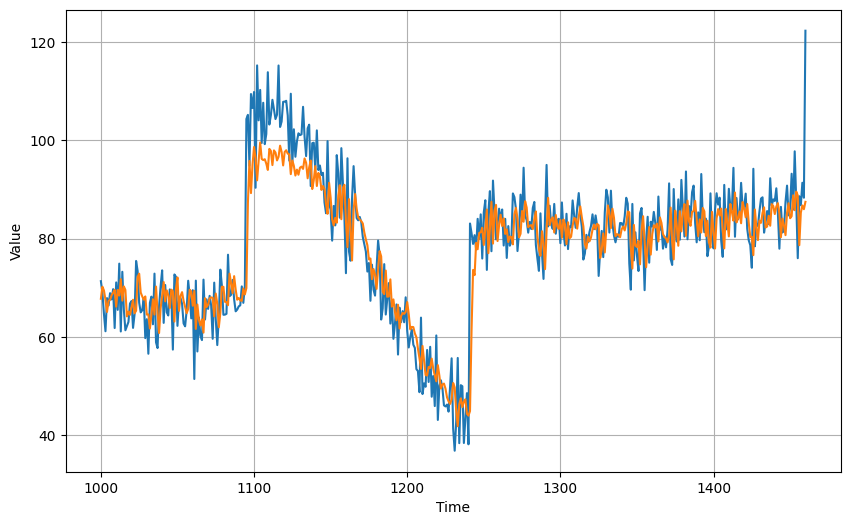

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# Sequence to Sequence Forecasting

In [12]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


2023-08-19 17:25:06.465731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [10,1]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:25:06.466122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [10,1]
	 [[{{node Placeholder/_0}}]]


In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


2023-08-19 17:25:45.484563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:25:45.484932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000,1]
	 [[{{node Placeholder/_0}}]]


      6/Unknown - 2s 25ms/step - loss: 81.9348 - mae: 82.4335  

2023-08-19 17:25:47.163704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:25:47.164019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461,1]
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 2s 71ms/step - loss: 73.2841 - mae: 73.7825 - val_loss: 21.9907 - val_mae: 22.4856
Epoch 2/500
8/8 [==============================] - 0s 34ms/step - loss: 46.6556 - mae: 47.1531 - val_loss: 75.5365 - val_mae: 76.0365
Epoch 3/500
8/8 [==============================] - 0s 34ms/step - loss: 35.5990 - mae: 36.0959 - val_loss: 19.2312 - val_mae: 19.7237
Epoch 4/500
8/8 [==============================] - 0s 35ms/step - loss: 26.0294 - mae: 26.5247 - val_loss: 23.4721 - val_mae: 23.9688
Epoch 5/500
8/8 [==============================] - 0s 34ms/step - loss: 20.4419 - mae: 20.9348 - val_loss: 23.1783 - val_mae: 23.6757
Epoch 6/500
8/8 [==============================] - 0s 35ms/step - loss: 16.5860 - mae: 17.0759 - val_loss: 15.8304 - val_mae: 16.3209
Epoch 7/500
8/8 [==============================] - 0s 33ms/step - loss: 14.9941 - mae: 15.4822 - val_loss: 13.2798 - val_mae: 13.7701
Epoch 8/500
8/8 [==============================] - 0s 33ms/step - loss: 13

In [17]:
rnn_forecast = model_forecast(model, series_noise[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

      1/Unknown - 0s 200ms/step

2023-08-19 17:26:58.373676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1461,1]
	 [[{{node Placeholder/_0}}]]
2023-08-19 17:26:58.373973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1461,1]
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 0s 6ms/step


5.217086

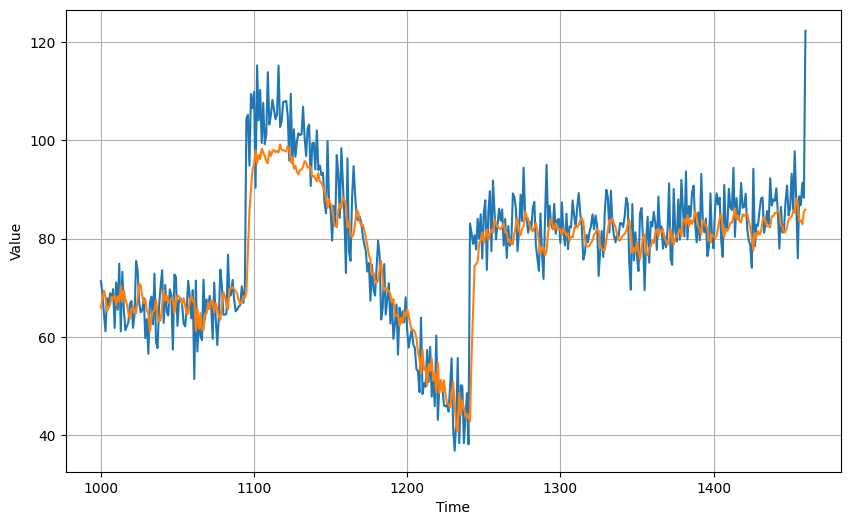

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()